German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 3 : Tracking and visualizing

Our main steps:
 - Monitoring and understanding our model training
 - Analyze the results 
 - Improving our model
 - Add recovery points


## 1/ Import and init

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, random
from importlib import reload

import idle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Wednesday 8 January 2020, 11:31:25
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use the dataset : **L25**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [3]:
%%time

dataset ='L25'
img_lx  = 25
img_ly  = 25
img_lz  = 1

# ---- Read dataset
x_train = np.load('./data/{}/x_train.npy'.format(dataset))
y_train = np.load('./data/{}/y_train.npy'.format(dataset))

x_test  = np.load('./data/{}/x_test.npy'.format(dataset))
y_test  = np.load('./data/{}/y_test.npy'.format(dataset))

# ---- Reshape data
x_train = x_train.reshape( x_train.shape[0], img_lx, img_ly, img_lz)
x_test  = x_test.reshape(  x_test.shape[0],  img_lx, img_ly, img_lz)

input_shape = (img_lx, img_ly, img_lz)

print("Dataset loaded, size={:.1f} Mo\n".format(ooo.get_directory_size('./data/'+dataset)))

Dataset loaded, size=247.6 Mo

CPU times: user 0 ns, sys: 328 ms, total: 328 ms
Wall time: 523 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 25, 25, 1)
y_train :  (39209,)
x_test  :  (12630, 25, 25, 1)
y_test  :  (12630,)


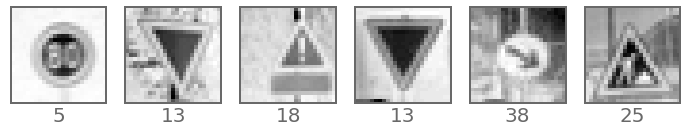

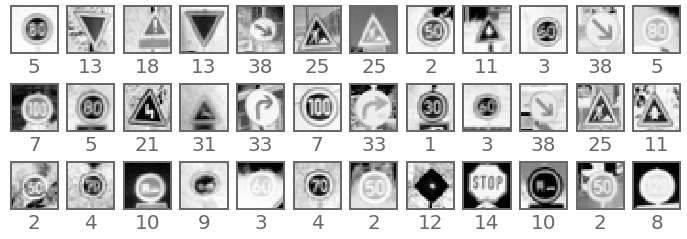

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

if img_lz>1:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(6),  columns=3,  x_size=4, y_size=3)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(36), columns=12, x_size=1, y_size=1)
else:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(6),  columns=6,  x_size=2, y_size=2)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model

In [122]:
batch_size  =  64
num_classes =  43
epochs      =  20

In [123]:
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(img_lx, img_ly, img_lz)))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(3072, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(43, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1

## 5/ Add callbacks
Nous allons ajouter 2 callbacks :  
 - **TensorBoard**  
Training logs, which can be visualised with Tensorboard.  
`#tensorboard --logdir ./run/logs`  
IMPORTANT : Relancer tensorboard à chaque run
 - **Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [124]:
# To clean logs and saved model, run this cell
!/bin/rm -r ./run/logs ./run/models
!/bin/ls -l ./run

total 0


In [125]:
ooo.mkdir('./run/models')
ooo.mkdir('./run/logs')

# ---- Callback tensorboard
log_dir = "./run/logs/tb_" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./run/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./run/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_freq=2000*5)

## 5/ Run model

In [126]:
%%time

history = model.fit(  x_train[:2000], y_train[:2000],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test[:200], y_test[:200]),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./run/models/last-model.h5')

Train on 2000 samples, validate on 200 samples
Epoch 1/20
2000/2000 [==============================] - 5s 3ms/sample - loss: 3.6179 - accuracy: 0.0595 - val_loss: 3.5203 - val_accuracy: 0.0550
Epoch 2/20
2000/2000 [==============================] - 5s 3ms/sample - loss: 3.4567 - accuracy: 0.0600 - val_loss: 3.4113 - val_accuracy: 0.0750
Epoch 3/20
2000/2000 [==============================] - 5s 3ms/sample - loss: 2.9967 - accuracy: 0.2045 - val_loss: 2.7160 - val_accuracy: 0.2450
Epoch 4/20
2000/2000 [==============================] - 5s 2ms/sample - loss: 2.1231 - accuracy: 0.3710 - val_loss: 2.2007 - val_accuracy: 0.3550
Epoch 5/20
2000/2000 [==============================] - 5s 2ms/sample - loss: 1.5418 - accuracy: 0.5290 - val_loss: 1.6167 - val_accuracy: 0.5050
Epoch 6/20
2000/2000 [==============================] - 5s 3ms/sample - loss: 1.1403 - accuracy: 0.6315 - val_loss: 1.6735 - val_accuracy: 0.5100
Epoch 7/20
2000/2000 [==============================] - 5s 3ms/sample - loss:

## 6/ History
The return of model.fit() returns us the learning history

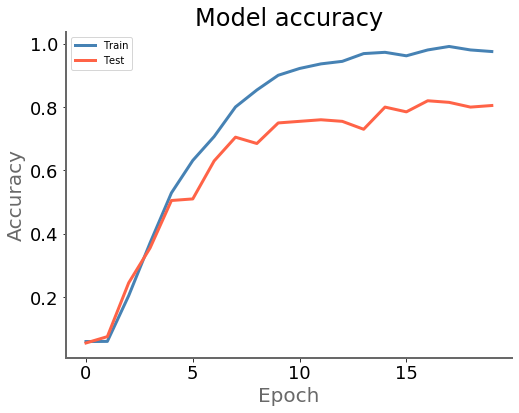

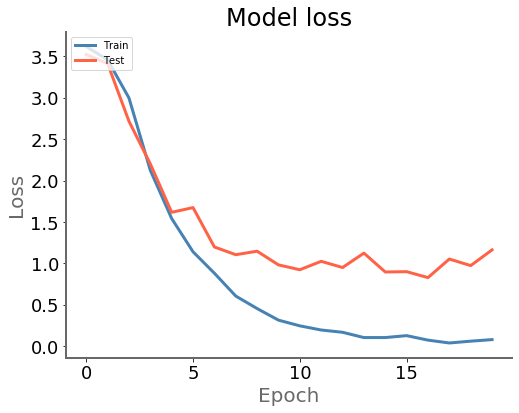

In [127]:
ooo.plot_history(history)

## 7/ Restore and evaluate
List of saved models :

In [4]:
!find ./run/models/

./run/models/
./run/models/best-model.h5
./run/models/last-model.h5


Restore current model :

In [7]:
best_model = tf.keras.models.load_model('./run/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


Evaluate it :

In [8]:
score = best_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.8608
Test accuracy  : 0.8466


Make a prediction :

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]]


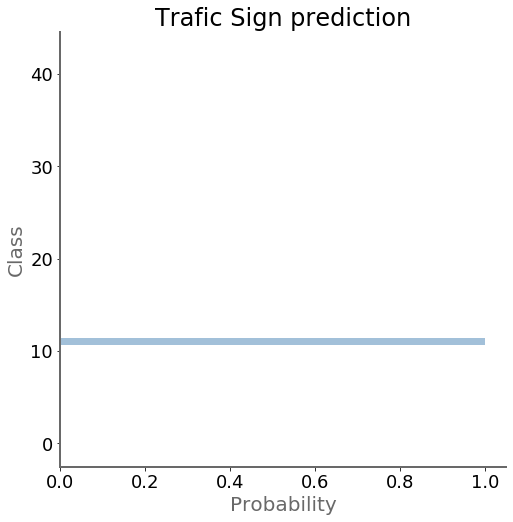

In [98]:
i   = random.randint(1,len(x_test))
x,y = x_test[i-1:i], y_test[i]
predictions = best_model.predict(x)
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)
    
plt.figure(figsize=(8,8))
plt.barh(range(43), predictions[0], align='center', alpha=0.5)
plt.xlabel('Probability')
plt.ylabel('Class')
plt.title('Trafic Sign prediction')
plt.show()

---
### A faire :
 - Restauration
 - Reprise apprentissage
 - Evaluation
 - Matrice de confusion
